In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from matplotlib import dates as mdates
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import argparse 
import sys
import os

#sys.path.insert(0, "Epidemiology_behavior_dynamics/run")
import config as cf


In [3]:
main_path = os.path.split(os.getcwd())[0]
config_path = main_path + '/config.csv'

config_data = pd.read_csv(config_path, sep=',', header=None, index_col=0)
config_data


config_data = pd.read_csv(config_path, sep=',', header=None, index_col=0)

networks_path = config_data.loc['networks_dir'][1]
results_path  = config_data.loc['results_dir'][1]
figures_path  = config_data.loc['figures_dir'][1]
awareness_path = config_data.loc['sigma_search_dir'][1]
infection_prob_path = config_data.loc['beta_search_dir'][1]
num_nodes     = 1000

sigma_search = pd.read_csv(os.path.join(main_path, awareness_path), dtype={'key':str, 'value':float})
beta_search  = pd.read_csv(os.path.join(main_path, infection_prob_path), dtype={'key':str, 'value':float})

time2Recover = (1/7)  # gamma

df = pd.concat([sigma_search, beta_search], axis=1)

list_df = []


for beta_fun in ["convex", "exponential", "linear", "concave", "s-shape"]:
    for type_sim in ["global", "local"]:
        #beta_fun = "linear"
        #type_sim = "global"

        df_param_run = pd.DataFrame(columns=['beta_key', 'sigma_key', 'beta_val', 'sigma_val', 'R0'])

        beta_key  = []
        sigma_key = []
        beta_val  = []
        sigma_val = []
        R0_val    = []
        for idx_sigma , r_sigma in sigma_search.iterrows():
            for idx_beta , r_beta in beta_search.iterrows():

                beta_key.append( r_beta['key']   )
                sigma_key.append( r_sigma['key'] )
                beta_val.append( r_beta['value'] )
                sigma_val.append( r_sigma['value'] )
                R0_val.append( r_beta['value'] / time2Recover )  # R0 = beta/gamma

        df_param_run['beta_key'] = beta_key  
        df_param_run['sigma_key'] = sigma_key 
        df_param_run['beta_val'] = beta_val  
        df_param_run['sigma_val'] = sigma_val 
        df_param_run['R0'] = R0_val

        for idx, r in tqdm(df_param_run.iterrows(), total=df_param_run.shape[0]):

            path_to_results = os.path.join(main_path, results_path, 
                                        beta_fun, 
                                        str(num_nodes), 
                                            type_sim, 
                                        "scale_free", 
                                        'dynamics_beta_{}_sigma_{}'.format(r['beta_key'], r['sigma_key']) +'.csv')
            res = pd.read_csv(path_to_results, usecols=['sim_id', 'time', 'S', 'I', 'C','D'])

            # Calculate mean over iterations.
            res = res.groupby('time').mean()/num_nodes
            res = res.reset_index()[['time', 'S', 'I', 'C','D']]
            res['beta']  = r['beta_val']
            res['sigma'] = r['sigma_val']
            res['R0']    = r['R0']

            res['beta_key']  = r['beta_key']
            res['sigma_key'] = r['sigma_key']
            res["type"]      = type_sim
            res["function"]  = beta_fun

            list_df.append(res)

df_response = pd.concat(list_df)



100%|██████████| 121/121 [00:01<00:00, 84.85it/s]


In [5]:
def return_pivoted_df(df_to_pivot, param, var='I'):
    df_heat_map = df_to_pivot.copy()
    df_heat_map = df_heat_map.pivot(param, 'sigma', var)
    df_heat_map = df_heat_map.iloc[::-1]

    return df_heat_map

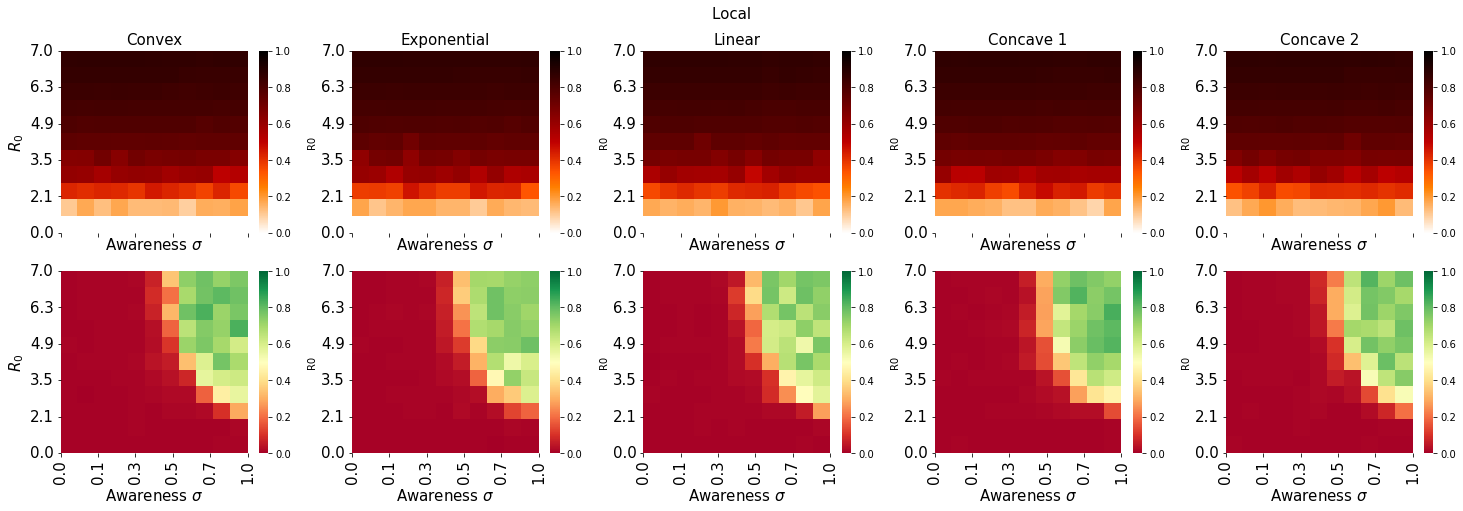

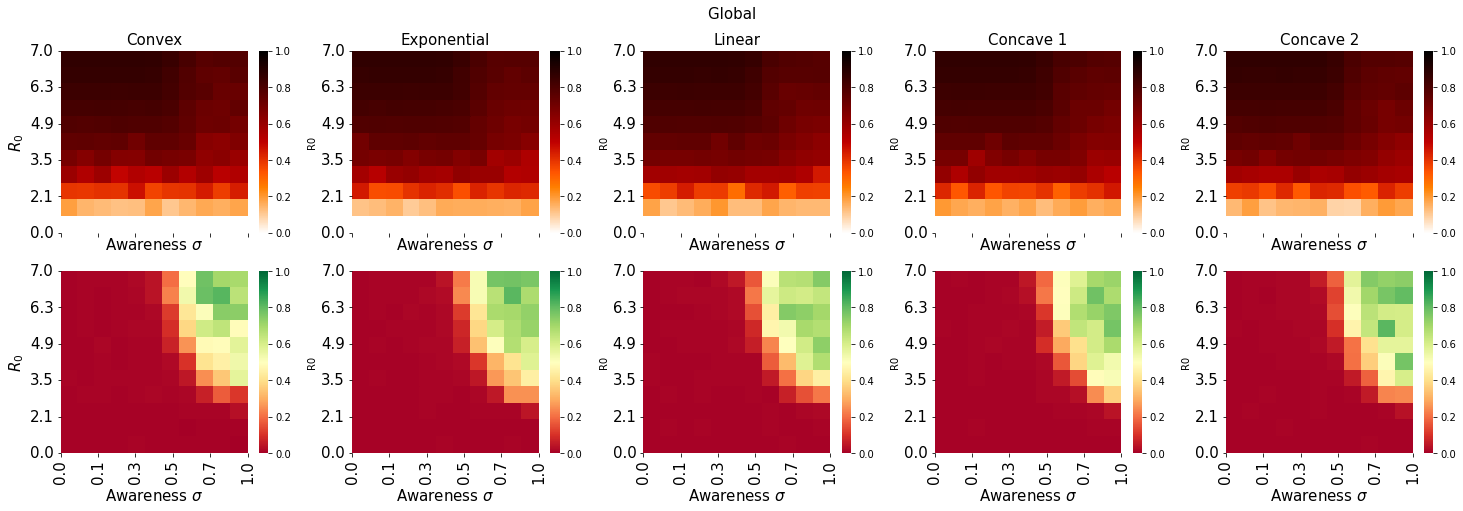

In [21]:
ssss_l = ["Convex", "Exponential", "Linear", "Concave 1", "Concave 2"]
ssss = ["convex", "exponential", "linear", "concave", "s-shape"]
for type_s in ["local", "global"]:
    fig, ax = plt.subplots(2, 5, figsize=(20.5, 7.2), sharex=True, sharey=False)
    for idx_t, ttype in enumerate(ssss):
        df_response_plt = df_response.copy()
        df_response_plt = df_response_plt[df_response_plt.function==ttype]
        df_response_plt = df_response_plt[df_response_plt.type==type_s]
        # df_response_plt = df_response_plt.reset_index()
        df_response_lastweek = df_response_plt.query("time >= 142")
        # steady state
        df_response_lastweek = df_response_lastweek.groupby(['R0', 'sigma']).mean()[['S', 'I', 'C','D']].reset_index()

        heatmap_epid = return_pivoted_df(df_response_lastweek, 'R0', 'I')
        heatmap_game = return_pivoted_df(df_response_lastweek, 'R0', 'C')

        sns.heatmap(ax = ax[0,idx_t], data=heatmap_epid, cmap='gist_heat_r',  cbar=True, vmin=0.0, vmax=1.0)
        sns.heatmap(ax = ax[1,idx_t], data=heatmap_game, cmap='RdYlGn',  cbar=True, vmin=0.0, vmax=1.0)

        ax[0,idx_t].set_title(f"{ssss_l[idx_t].capitalize()}", fontsize=15)


    ax[0,0].set_ylabel(r'$R_{0}$', fontsize=15)
    ax[1,0].set_ylabel(r'$R_{0}$', fontsize=15)

    
    xticks = heatmap_epid.columns
    keptxticksidx = np.linspace(0,len(xticks),6)
    xtickslabels = list(xticks[ np.maximum(keptxticksidx.astype(int)-1,0) ])
    xtickslabels = ['{:.1f}'.format(l) for l in xtickslabels]


    yticks = heatmap_epid.index
    keptyticksidx = np.linspace(0,len(yticks),6)
    ytickslabels = list(yticks[ np.maximum(keptyticksidx.astype(int)-1,0) ])
    ytickslabels = ['{:.1f}'.format(l) for l in ytickslabels]

    

    for idx, axi in enumerate(ax.flatten()):
        # axi.xaxis.set_major_locator(mdates.MonthLocator())
        # axi.xaxis.set_minor_locator(mdates.WeekdayLocator())
        axi.set_xticks(keptxticksidx)
        axi.set_xticklabels(xtickslabels, fontsize=20, rotation=0)
        axi.set_yticks(keptyticksidx)
        axi.set_yticklabels(ytickslabels, fontsize=20)
        axi.tick_params( which='both', axis='both', labelsize=15)
        axi.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
        axi.spines['right'].set_visible(False)
        axi.spines['top'].set_visible(False)
        axi.set_xlabel(r'Awareness $\sigma$', fontsize=15)

    fig.suptitle(f"{type_s.capitalize()} ", fontsize=15) 
    plt.tight_layout()

    if not os.path.isdir( os.path.join(figures_path, 'test' ) ):
        os.makedirs( os.path.join(figures_path, 'test' ) )

    path_save = os.path.join(figures_path, 'test' )
    plt.savefig(os.path.join(path_save, 'heatmap_{}.png'.format(type_s)), 
                        dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.1)
    
